### BGS Target Properties

In [1]:
import os, pdb
import datetime
import numpy as np
import fitsio
from astropy.table import Table, hstack, Column
from astropy.stats import sigma_clipped_stats

from desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask, mws_mask

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

sns.set(context='talk', style='ticks', palette='deep', font_scale=1.3)#, rc=rc)
colors = sns.color_palette()

pref = {'ELG': {'color': colors[0], 'marker': 's'},
        'LRG': {'color': colors[3], 'marker': '^'},
        'QSO': {'color': colors[4], 'marker': 'x'},
        'BGS_ANY': {'color': colors[8], 'marker': 'o'}
       }

%matplotlib inline

In [5]:
specprod = 'cascades'
rootdir = os.path.join(os.getenv('DESI_ROOT'), 'spectro', 'fastspecfit')
expdir = os.path.join(os.getenv('DESI_ROOT'), 'survey', 'observations', 'SV1')
datadir = os.path.join(rootdir, specprod, 'tiles', 'merged')
figdir = os.path.join(os.getenv('HOME'), 'research', 'talks', '2021', '21Mar25-cascades')
print(figdir)
print(datadir)

/Users/ioannis/research/talks/2021/21Mar25-cascades
/Users/ioannis/work/desi/spectro/fastspecfit/cascades/tiles/merged


In [6]:
expinfo = Table(fitsio.read(os.path.join(expdir, 'sv1-exposures.fits')))
print(expinfo.colnames)

['NIGHT', 'EXPID', 'FIELD', 'TARGETS', 'OBSCONDITIONS', 'ARIZONA_TIMEOBS', 'EBV', 'SPECMODEL_SKY_GFLUX', 'SPECMODEL_SKY_RFLUX', 'SPECMODEL_SKY_ZFLUX', 'GFA_ORIGIN', 'B_DEPTH', 'R_DEPTH', 'Z_DEPTH', 'B_DEPTH_EBVAIR', 'R_DEPTH_EBVAIR', 'Z_DEPTH_EBVAIR', 'EFFTIME_DARK', 'EFFTIME_BRIGHT', 'EFFTIME_BACKUP', 'SPEED_DARK', 'SPEED_BRIGHT', 'SPEED_BACKUP', 'SPECPROD', 'SPECPROD_BITPSFFN', 'SPECPROD_BITFRAMEFN', 'SPECPROD_BITSKYFN', 'SPECPROD_BITSFRAMEFN', 'SPECPROD_BITFLUXCALIBFN', 'SPECPROD_BITCFRAMEFN', 'TSNR2_BGS', 'TSNR2_LRG', 'TSNR2_ELG', 'TSNR2_QSO', 'TILEID', 'TILERA', 'TILEDEC', 'EXPTIME', 'MJDOBS', 'N_ASSGN_TGT', 'N_ASSGN_SKY', 'N_ASSGN_STD', 'N_ASSGN_WD', 'N_ASSGN_LRG', 'N_ASSGN_ELG', 'N_ASSGN_QSO', 'N_ASSGN_BGS', 'N_ASSGN_MWS', 'SKYMON_NEXP', 'SKYMON_SKYCAM0_MEAN', 'SKYMON_SKYCAM0_MEAN_ERR', 'SKYMON_SKYCAM1_MEAN', 'SKYMON_SKYCAM1_MEAN_ERR', 'SKYMON_AVERAGE_MEAN', 'SKYMON_AVERAGE_MEAN_ERR', 'GFA_AIRMASS', 'GFA_MOON_ILLUMINATION', 'GFA_MOON_ZD_DEG', 'GFA_MOON_SEP_DEG', 'GFA_TRANSPARENC

In [65]:
fitsio.FITS(os.path.join(datadir, 'fastspec-cascades-deep.fits'))[2]


  file: /Users/ioannis/work/desi/spectro/fastspecfit/cascades/tiles/merged/fastspec-cascades-deep.fits
  extension: 2
  type: BINARY_TBL
  extname: METADATA
  rows: 9599
  column info:
    TARGETID            i8  
    RA                  f8  
    DEC                 f8  
    FIBER               i4  
    TILEID              i4  
    PHOTSYS             S1  
    SV1_DESI_TARGET     i8  
    SV1_BGS_TARGET      i8  
    SV1_MWS_TARGET      i8  
    DESI_TARGET         i8  
    BGS_TARGET          i8  
    MWS_TARGET          i8  
    Z                   f8  
    ZWARN               i8  
    DELTACHI2           f8  
    SPECTYPE            S6  
    FIBERFLUX_G         f4  
    FIBERFLUX_R         f4  
    FIBERFLUX_Z         f4  
    FIBERTOTFLUX_G      f4  
    FIBERTOTFLUX_R      f4  
    FIBERTOTFLUX_Z      f4  
    FLUX_G              f4  
    FLUX_R              f4  
    FLUX_Z              f4  
    FLUX_W1             f4  
    FLUX_W2             f4  
    FLUX_IVAR_G         f4  
  

In [25]:
def read_results():
    specfile = os.path.join(datadir, 'fastspec-cascades-deep.fits')
    spec = hstack((Table(fitsio.read(specfile, 'FASTSPEC')), 
                   Table(fitsio.read(specfile, 'METADATA'))), 
                  join_type='inner')
    spec.remove_column('TARGETID_2')
    spec.rename_column('TARGETID_1', 'TARGETID')

    photfile = os.path.join(datadir, 'fastphot-cascades-deep.fits')
    phot = hstack((Table(fitsio.read(photfile, 'FASTPHOT')), 
                   Table(fitsio.read(photfile, 'METADATA'))), 
                  join_type='inner')
    phot.remove_column('TARGETID_2')
    phot.rename_column('TARGETID_1', 'TARGETID')

    skey = np.array(['{}-{}'.format(tile, tid) for tile, tid in zip(spec['TILEID'], spec['TARGETID'])])
    pkey = np.array(['{}-{}'.format(tile, tid) for tile, tid in zip(phot['TILEID'], phot['TARGETID'])])
    _, sindx, pindx = np.intersect1d(skey, pkey, return_indices=True)    

    spec = spec[sindx]
    phot = phot[pindx]

    assert(np.all(spec['TARGETID'] == phot['TARGETID']))
    assert(np.all(spec['TILEID'] == phot['TILEID']))
    
    print('Read {} objects from {}'.format(len(spec), specfile))
    print('Read {} objects from {}'.format(len(phot), photfile))
    ngal = len(spec)
    
    for band in ('G', 'R', 'Z', 'W1'):
        phot['{}MAG'.format(band)] = 22.5 - 2.5 * np.log10(phot['FLUX_{}'.format(band)])
    for band in ('G', 'R', 'Z'):
        phot['{}FIBERMAG'.format(band)] = 22.5 - 2.5 * np.log10(phot['FIBERFLUX_{}'.format(band)])
    
    # convenience targeting variables
    for targ in ['BGS_ANY', 'ELG', 'LRG', 'QSO', 'MWS_ANY']:
        phot[targ] = spec['SV1_DESI_TARGET'] & desi_mask.mask(targ) != 0
        spec[targ] = spec['SV1_DESI_TARGET'] & desi_mask.mask(targ) != 0
    
    return phot, spec

allphot, allspec = read_results()
#spec

Read 9599 objects from /Users/ioannis/work/desi/spectro/fastspecfit/cascades/tiles/merged/fastspec-cascades-deep.fits
Read 9599 objects from /Users/ioannis/work/desi/spectro/fastspecfit/cascades/tiles/merged/fastphot-cascades-deep.fits


<ipython-input-25-ca37b7388e3b>:31: RuntimeWarning: divide by zero encountered in log10
  phot['{}MAG'.format(band)] = 22.5 - 2.5 * np.log10(phot['FLUX_{}'.format(band)])
<ipython-input-25-ca37b7388e3b>:31: RuntimeWarning: invalid value encountered in log10
  phot['{}MAG'.format(band)] = 22.5 - 2.5 * np.log10(phot['FLUX_{}'.format(band)])
<ipython-input-25-ca37b7388e3b>:33: RuntimeWarning: divide by zero encountered in log10
  phot['{}FIBERMAG'.format(band)] = 22.5 - 2.5 * np.log10(phot['FIBERFLUX_{}'.format(band)])


In [19]:
print(allphot.colnames)

['TARGETID', 'CONTINUUM_COEFF', 'CONTINUUM_CHI2', 'CONTINUUM_AGE', 'CONTINUUM_AV', 'CONTINUUM_AV_IVAR', 'D4000_MODEL', 'KCORR_U', 'ABSMAG_U', 'ABSMAG_IVAR_U', 'KCORR_G', 'ABSMAG_G', 'ABSMAG_IVAR_G', 'KCORR_R', 'ABSMAG_R', 'ABSMAG_IVAR_R', 'KCORR_I', 'ABSMAG_I', 'ABSMAG_IVAR_I', 'KCORR_Z', 'ABSMAG_Z', 'ABSMAG_IVAR_Z', 'KCORR_W1', 'ABSMAG_W1', 'ABSMAG_IVAR_W1', 'RA', 'DEC', 'FIBER', 'TILEID', 'PHOTSYS', 'SV1_DESI_TARGET', 'SV1_BGS_TARGET', 'SV1_MWS_TARGET', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET', 'Z', 'ZWARN', 'DELTACHI2', 'SPECTYPE', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z', 'FIBERTOTFLUX_G', 'FIBERTOTFLUX_R', 'FIBERTOTFLUX_Z', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'GMAG', 'RMAG', 'ZMAG', 'W1MAG', 'GFIBERMAG', 'RFIBERMAG', 'ZFIBERMAG', 'BGS_ANY', 'ELG', 'LRG', 'QSO', 'MWS_ANY']


In [27]:
set(allphot['TILEID'])

{80607, 80608, 80613}

#### Select mildly deep BGS tiles

2877 9599
[80641 80642 80643 80644 80645 80646 80647 80648 80649 80650 80651 80652
 80653 80654 80655 80656 80657 80658 80659 80660 80661 80662 80663 80664
 80665 80666 80611 80612 80613 80614 80742 80616 80617 80618 80619 80740
 80741 80624 80627 80629 80632 80633 80635 80638]
[80613]


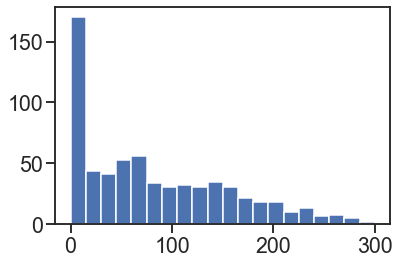

In [20]:
expbgs_all = expinfo['TARGETS'] == 'BGS+MWS'
expbgs_deep = (expinfo['TARGETS'] == 'BGS+MWS') * (expinfo['EFFTIME_BRIGHT'] > 120)
_ = plt.hist(expinfo['EFFTIME_BRIGHT'][expbgs_all], bins=20, range=(0, 300))
expbgs = expinfo[expbgs_deep]
thesetiles = np.array(list(set(expbgs['TILEID'])))

I = np.isin(allphot['TILEID'], thesetiles)
phot = allphot[I]
spec = allspec[I]
print(len(spec), len(allspec))
print(thesetiles)
print(np.array(list(set(spec['TILEID']))))

2443


Text(0, 0.5, '$(z - w1) - 3 (g - r) / 2.5 + 1.2$')

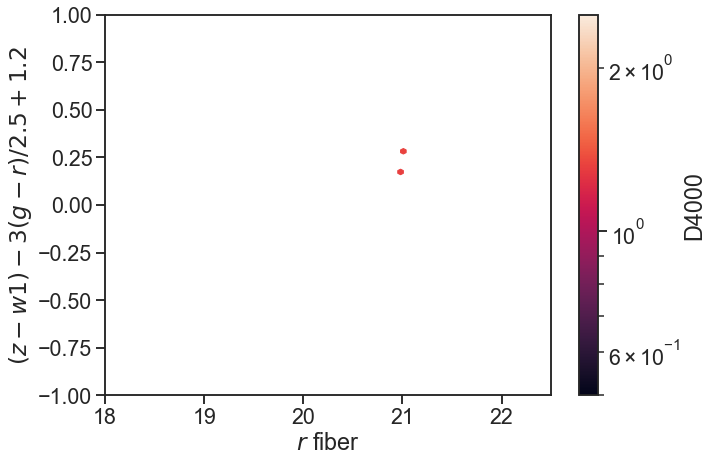

In [21]:
xlim = (18, 22.5)
ylim = (-1, 1)
I = np.where(
    (spec['ZWARN'] == 0) * (spec['SPECTYPE'] != 'STAR') * 
    #(spec['CONTINUUM_SNR'][:, 1] > 5) * 
    (phot['FLUX_G'] > 0) * (phot['FLUX_R'] > 0) * (phot['FLUX_Z'] > 0) * 
    (phot['FLUX_W1'] > 0) * (phot['FIBERTOTFLUX_R'] > 0) *              
    (phot['D4000_MODEL'] > 0.5) * (phot['D4000_MODEL'] < 2.5)
)[0]
print(len(I))
schlegel_color = (phot['ZMAG'][I] - phot['W1MAG'][I]) - 3/2.5 * (phot['GMAG'][I] - phot['RMAG'][I]) + 1.2

fig, ax = plt.subplots(figsize=(10, 7))
im = ax.hexbin(phot['RFIBERMAG'][I], schlegel_color, mincnt=5,
               gridsize=80, vmin=0.5, vmax=2.5, bins='log',
               extent=np.hstack((xlim, ylim)), C=phot['D4000_MODEL'][I], reduce_C_function=np.mean)
#cax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
cb = fig.colorbar(im, label='D4000')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(r'$r$ fiber')
ax.set_ylabel(r'$(z - w1) - 3 (g - r) / 2.5 + 1.2$')

In [22]:
def get_oii(spec):
    ioii = np.where(
        (spec['OII_3726_AMP'] * spec['OII_3726_AMP_IVAR'] > 3) * 
        (spec['OII_3729_AMP'] * spec['OII_3729_AMP_IVAR'] > 3) * 
        (spec['OII_3726_EW'] > 0) * 
        (spec['OII_3729_EW'] > 0) *
        (phot['D4000_MODEL'] > 0) * (phot['D4000_MODEL'] < 2.5))[0]
    ewoii = np.log10(spec['OII_3726_EW'][ioii] + spec['OII_3729_EW'][ioii])
    d4000 = phot['D4000_MODEL'][ioii]
    return ewoii, d4000

<ipython-input-22-386578db0b7b>:3: RuntimeWarning: invalid value encountered in multiply
  (spec['OII_3726_AMP'] * spec['OII_3726_AMP_IVAR'] > 3) *
/Users/ioannis/anaconda3/envs/desi/lib/python3.8/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
<ipython-input-22-386578db0b7b>:4: RuntimeWarning: invalid value encountered in multiply
  (spec['OII_3729_AMP'] * spec['OII_3729_AMP_IVAR'] > 3) *


(0, 3.5)

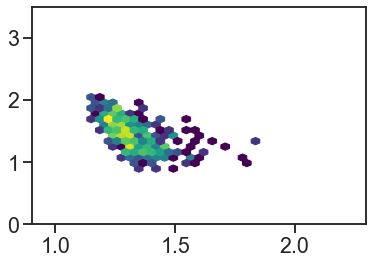

In [23]:
ewoii, d4000 = get_oii(spec)
plt.hexbin(d4000, ewoii, mincnt=3, gridsize=30, cmap='viridis', bins='log')
plt.xlim(0.9, 2.3)
plt.ylim(0, 3.5)

In [24]:
print(phot.colnames)

['TARGETID', 'CONTINUUM_COEFF', 'CONTINUUM_CHI2', 'CONTINUUM_AGE', 'CONTINUUM_AV', 'CONTINUUM_AV_IVAR', 'D4000_MODEL', 'KCORR_U', 'ABSMAG_U', 'ABSMAG_IVAR_U', 'KCORR_G', 'ABSMAG_G', 'ABSMAG_IVAR_G', 'KCORR_R', 'ABSMAG_R', 'ABSMAG_IVAR_R', 'KCORR_I', 'ABSMAG_I', 'ABSMAG_IVAR_I', 'KCORR_Z', 'ABSMAG_Z', 'ABSMAG_IVAR_Z', 'KCORR_W1', 'ABSMAG_W1', 'ABSMAG_IVAR_W1', 'RA', 'DEC', 'FIBER', 'TILEID', 'PHOTSYS', 'SV1_DESI_TARGET', 'SV1_BGS_TARGET', 'SV1_MWS_TARGET', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET', 'Z', 'ZWARN', 'DELTACHI2', 'SPECTYPE', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z', 'FIBERTOTFLUX_G', 'FIBERTOTFLUX_R', 'FIBERTOTFLUX_Z', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'GMAG', 'RMAG', 'ZMAG', 'W1MAG', 'GFIBERMAG', 'RFIBERMAG', 'ZFIBERMAG', 'BGS_ANY', 'ELG', 'LRG', 'QSO', 'MWS_ANY']


In [ ]:
stop

9


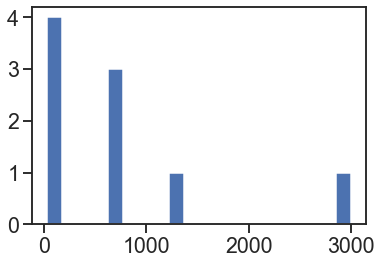

In [28]:
ww = np.where(spec['BROAD_SIGMA'] > 0)[0]
print(len(ww))
_ = plt.hist(spec['BROAD_SIGMA'][ww], bins=20)

1633 1700


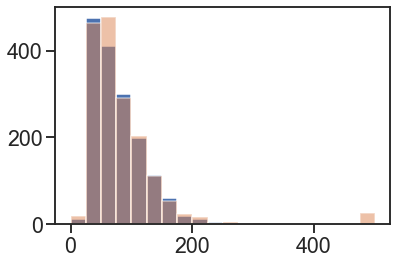

In [29]:
w1 = np.where(spec['BALMER_SIGMA'] > 0)[0]
w2 = np.where(spec['FORBIDDEN_SIGMA'] > 0)[0]
print(len(w1), len(w2))
_ = plt.hist(spec['BALMER_SIGMA'][w1], bins=20, range=(0, 500))
_ = plt.hist(spec['FORBIDDEN_SIGMA'][w2], bins=20, range=(0, 500), alpha=0.5)

In [30]:
w1 = np.where(spec['MGII_2800_AMP']*spec['MGII_2800_AMP_IVAR'] > 3)[0]
len(w1)

<ipython-input-30-4d3603306036>:1: RuntimeWarning: invalid value encountered in multiply
  w1 = np.where(spec['MGII_2800_AMP']*spec['MGII_2800_AMP_IVAR'] > 3)[0]


38

LRG 2063
QSO 1451
ELG 4443
BGS_ANY 2925
Writing /Users/ioannis/research/talks/2021/21Mar25-cascades/zhist.png


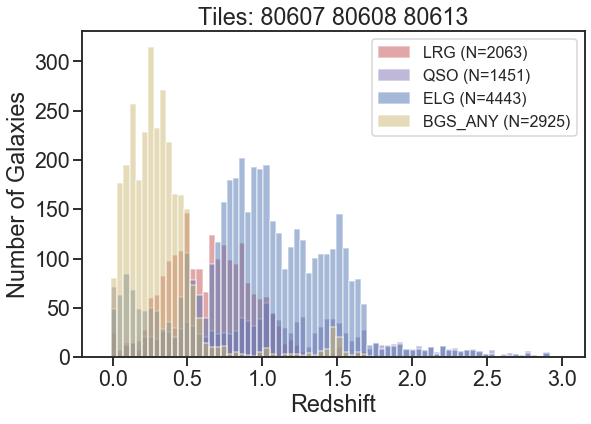

In [38]:
def zhist(png=None):
    fig, ax = plt.subplots(figsize=(9, 6))
    for targ in ['LRG', 'QSO', 'ELG', 'BGS_ANY']:
        itarg = np.where(allspec[targ])[0]
        print(targ, len(itarg))
 
        _ = ax.hist(allspec['CONTINUUM_Z'][itarg], label='{} (N={})'.format(targ, len(itarg)), 
                    range=(-0.05, 3.0), bins=75, alpha=0.5,
                    color=pref[targ]['color'])
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
        #ax.yaxis.set_major_locator(ticker.MultipleLocator(500))
    
    ax.legend(fontsize=16)
    ax.set_xlabel('Redshift')
    ax.set_ylabel('Number of Galaxies')
    ax.set_title('Tiles: {}'.format(' '.join(sorted(set(allspec['TILEID'].astype(str))))))
    
    if png:
        print('Writing {}'.format(png))
        fig.savefig(png)
        
zhist(png=os.path.join(figdir, 'zhist.png'))

In [53]:
bb = allspec[np.isnan(allspec['MGII_2800_AMP'] * allspec['MGII_2800_AMP_IVAR'])]
bb['TARGETID', 'TILEID', 'FIBER']

<ipython-input-53-5c50fb5aa349>:1: RuntimeWarning: invalid value encountered in multiply
  bb = allspec[np.isnan(allspec['MGII_2800_AMP'] * allspec['MGII_2800_AMP_IVAR'])]


TARGETID,TILEID,FIBER
int64,int32,int32
39633314159527156,80607,465
39633338297750059,80613,1586
39633345025410833,80613,3229
39633348326327633,80613,2199


In [56]:
2199 // 500

4

<ipython-input-59-31bde38fa987>:26: RuntimeWarning: invalid value encountered in multiply
  ((allspec['MGII_2800_AMP'] * allspec['MGII_2800_AMP_IVAR']) > 3.0)))[0]
/Users/ioannis/anaconda3/envs/desi/lib/python3.8/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
<ipython-input-59-31bde38fa987>:28: RuntimeWarning: invalid value encountered in multiply
  ((allspec['MGII_2800_AMP'] * allspec['MGII_2800_AMP_IVAR']) <= 3.0)))[0]
/Users/ioannis/anaconda3/envs/desi/lib/python3.8/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less_equal
  result = getattr(super(), op)(other)
<ipython-input-59-31bde38fa987>:35: RuntimeWarning: invalid value encountered in multiply
  ((allspec['MGII_2800_AMP'] * allspec['MGII_2800_AMP_IVAR']) > 3.0))[0]
<ipython-input-59-31bde38fa987>:38: RuntimeWarning: invalid value encountered in multiply
  ((allspec['MGII_2800_AMP'] * allspec['MGII_

Number of QSOs: 1451
Writing /Users/ioannis/research/talks/2021/21Mar25-cascades/frac-qso-mgii.png


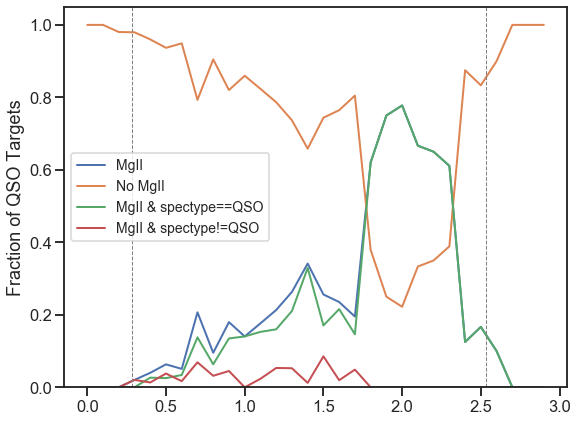

In [59]:
def zhist_bins(deltaz=0.1, zmin=0.0, zmax=2, target='QSO', binedges=False):
    if target.strip() == 'LRG':
        zmin, zmax = 0.0, 1.2
    elif target.strip() == 'BGS':
        zmin, zmax = 0.0, 0.5
    elif target.strip() == 'QSO':
        zmin, zmax = 0.0, 3.0
    else:
        pass
    if binedges:
        bins = np.arange(zmin, zmax, deltaz) # bin left edges
    else:
        bins = np.arange(zmin, zmax, deltaz) + deltaz / 2 # bin centers
    return bins

def zhist_type(data, target='QSO'):
    bins = zhist_bins(target=target, binedges=True)
    hist, _ = np.histogram(data, bins=len(bins), range=(bins.min(), bins.max()))
    return hist, bins

def qso_mgii(png=None):

    iqso = np.where(allspec['SV1_DESI_TARGET'] & desi_mask.mask('QSO') != 0)[0]
    
    iqso_mgii = np.where(((allspec['SV1_DESI_TARGET'] & desi_mask.mask('QSO') != 0) * 
                         ((allspec['MGII_2800_AMP'] * allspec['MGII_2800_AMP_IVAR']) > 3.0)))[0]
    iqso_nomgii = np.where(((allspec['SV1_DESI_TARGET'] & desi_mask.mask('QSO') != 0) * 
                            ((allspec['MGII_2800_AMP'] * allspec['MGII_2800_AMP_IVAR']) <= 3.0)))[0]
    
    #iqso_redrock = np.where((allspec['SV1_DESI_TARGET'] & desi_mask.mask('QSO') != 0) *
    #                        (allspec['SPECTYPE'] == 'QSO'))[0]

    iqso_redrock_qso_mgii = np.where((allspec['SV1_DESI_TARGET'] & desi_mask.mask('QSO') != 0) *
                                     (allspec['SPECTYPE'] == 'QSO') *
                                     ((allspec['MGII_2800_AMP'] * allspec['MGII_2800_AMP_IVAR']) > 3.0))[0]
    iqso_redrock_notqso_mgii = np.where((allspec['SV1_DESI_TARGET'] & desi_mask.mask('QSO') != 0) *
                                      (allspec['SPECTYPE'] != 'QSO') *
                                      ((allspec['MGII_2800_AMP'] * allspec['MGII_2800_AMP_IVAR']) > 3.0))[0]

    print('Number of QSOs: {}'.format(len(iqso)))
    #print('Number of QSOs with MgII: {}'.format(len(iqso_mgii)))
    #print('Number with QSOs with spectype==QSO: {}'.format(len(iqso_redrock)))
    #print('Number with QSOs with spectype==QSO and MgII: {}'.format(len(iqso_redrock_mgii)))

    with sns.plotting_context(context='talk', font_scale=1.0):    
        fig, ax = plt.subplots(figsize=(9, 7))
        
        allhist, zbins = zhist_type(allspec['Z'][iqso])

        mgii_hist, _ = zhist_type(allspec['Z'][iqso_mgii])
        nomgii_hist, _ = zhist_type(allspec['Z'][iqso_nomgii])
        redrock_qso_mgii_hist, _ = zhist_type(allspec['Z'][iqso_redrock_qso_mgii])
        redrock_notqso_mgii_hist, _ = zhist_type(allspec['Z'][iqso_redrock_notqso_mgii])
        
        zgood = np.where(allhist > 0)[0]
        
        ax.plot(zbins[zgood], mgii_hist[zgood]/allhist[zgood], 
                ls='-', lw=2, label='MgII')
        ax.plot(zbins[zgood], nomgii_hist[zgood]/allhist[zgood], 
                ls='-', lw=2, label='No MgII')
        ax.plot(zbins[zgood], redrock_qso_mgii_hist[zgood]/allhist[zgood], 
                ls='-', lw=2, label='MgII & spectype==QSO')
        ax.plot(zbins[zgood], redrock_notqso_mgii_hist[zgood]/allhist[zgood], 
                ls='-', lw=2, label='MgII & spectype!=QSO')
        
        ax.set_ylim(0, 1.05)
        ax.set_ylabel('Fraction of QSO Targets')
        ax.axvline(x=3600/2800-1, ls='--', lw=1, color='gray')
        ax.axvline(x=9900/2800-1, ls='--', lw=1, color='gray')
        ax.legend(fontsize=14)
        
    if png:
        print('Writing {}'.format(png))
        fig.savefig(png)
        
qso_mgii(png=os.path.join(figdir, 'frac-qso-mgii.png'))

In [58]:
stop

NameError: name 'stop' is not defined

In [ ]:
def read_results():
    specfile = os.path.join(datadir, 'fastspec-night-coadds.fits')
    spec = hstack((Table(fitsio.read(specfile, 'FASTSPEC')), 
                   Table(fitsio.read(specfile, 'METADATA'))), 
                  join_type='inner')
    spec.remove_column('TARGETID_2')
    spec.rename_column('TARGETID_1', 'TARGETID')

    photfile = os.path.join(datadir, 'fastphot-night-coadds.fits')
    phot = hstack((Table(fitsio.read(photfile, 'FASTPHOT')), 
                   Table(fitsio.read(photfile, 'METADATA'))), 
                  join_type='inner')
    phot.remove_column('TARGETID_2')
    phot.rename_column('TARGETID_1', 'TARGETID')

    skey = np.array(['{}-{}-{}'.format(night, tile, tid) 
                     for night, tile, tid in zip(spec['NIGHT'], spec['TILEID'], spec['TARGETID'])])
    pkey = np.array(['{}-{}-{}'.format(night, tile, tid) 
                     for night, tile, tid in zip(phot['NIGHT'], phot['TILEID'], phot['TARGETID'])])
    _, sindx, pindx = np.intersect1d(skey, pkey, return_indices=True)    

    spec = spec[sindx]
    phot = phot[pindx]

    assert(np.all(spec['TARGETID'] == phot['TARGETID']))
    assert(np.all(spec['NIGHT'] == phot['NIGHT']))
    assert(np.all(spec['TILEID'] == phot['TILEID']))
    
    print('Read {} objects from {}'.format(len(spec), specfile))
    print('Read {} objects from {}'.format(len(phot), photfile))
    ngal = len(spec)
    
    # convenience targeting variables
    for targ in ['BGS_ANY', 'ELG', 'LRG', 'QSO', 'MWS_ANY']:
        phot[targ] = spec['SV1_DESI_TARGET'] & desi_mask.mask(targ) != 0
    
    # row-match to the conditions file
    newcols = ['TRANSP', 'SEEING', 'SKYMAG_GFA', 'SKYMAG_SPEC', 'AIRMASS', 
               'MOONFRAC', 'MOONZD', 'MOONSEP', 'FIBER_FRACFLUX', 'R_DEPTH']
    for col in newcols:
        phot.add_column(Column(name=col, length=ngal, dtype='f4'))

    for expnight in set(expinfo['NIGHT']):
        for exptile in set(expinfo['TILEID']):
            I = np.where((expnight == expinfo['NIGHT']) * (exptile == expinfo['TILEID']))[0]
            J = np.where((expnight == spec['NIGHT']) * (exptile == spec['TILEID']))[0]
            if len(J) > 0:
                phot['TRANSP'][J] = np.nanmean(expinfo['GFA_TRANSPARENCY_MED'][I])
                phot['SEEING'][J] = np.nanmean(expinfo['GFA_FWHM_ASEC_MED'][I])
                phot['SKYMAG_GFA'][J] = np.nanmean(expinfo['GFA_SKY_MAG_AB_MED'][I])
                phot['SKYMAG_SPEC'][J] = np.nanmean(expinfo['SPECMODEL_SKY_RMAG_AB'][I])
                phot['AIRMASS'][J] = np.nanmean(expinfo['GFA_AIRMASS_MED'][I])
                phot['MOONFRAC'][J] = np.nanmean(expinfo['GFA_MOON_ILLUMINATION_MEAN'][I])
                phot['MOONZD'][J] = np.nanmean(expinfo['GFA_MOON_ZD_DEG_MEAN'][I])
                phot['MOONSEP'][J] = np.nanmean(expinfo['GFA_MOON_SEP_DEG_MEAN'][I])
                phot['FIBER_FRACFLUX'][J] = np.nanmean(expinfo['GFA_FIBER_FRACFLUX_MEAN'][I])
                phot['R_DEPTH'][J] = np.nanmean(expinfo['R_DEPTH'][I])
                
    return phot, spec

In [ ]:
stop

In [ ]:
%time phot, spec = read_results()

In [ ]:
#pp = phot[phot['TILEID'] == 80611]
#ll = pp[pp['SV1_DESI_TARGET'] & desi_mask.mask('LRG') != 0]
#len(ll), len(set(ll['TARGETID']))

In [ ]:
print(phot.colnames)

In [ ]:
print(spec.colnames)